In [36]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm


from dataset import patch_dataset
from trainer import train
from models import basic_FCN, UNet

In [4]:
file_path_X = 'X_train'
file_path_Y = 'Y_train'
index = np.load('X_train/_index_good.npy')

dataset = patch_dataset(file_path_X, file_path_Y,index,load_in_ram=True, numtype=torch.float32)
dataset.X = dataset.X.unsqueeze(1)
print(dataset.X.shape)  # Should print (3423, 1, 160, 272)

dataset.Y = dataset.Y.permute(0, 3, 1, 2)
print(dataset.Y.shape)  # Should print (3423, 3, 160, 272)

torch.Size([3423, 1, 160, 272])
torch.Size([3423, 3, 160, 272])


In [9]:
batch_size = 64

dataloader = DataLoader(dataset, batch_size, shuffle=True)

for x,y in tqdm(dataloader):
    print(x.shape)
    print(y.shape)
    break

  0%|          | 0/54 [00:00<?, ?it/s]

torch.Size([64, 1, 160, 272])
torch.Size([64, 3, 160, 272])


In [38]:
model = UNet(in_channels=1, out_channels=3, features=[32, 64, 128, 256])
model.to('mps')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = criterion = torch.nn.CrossEntropyLoss()

In [7]:
x, y = next(iter(dataloader))
x = x.to('mps')
y = y.to('mps')
model(x).shape

torch.Size([10, 3, 160, 272])

In [40]:
train(model, optimizer, loss_fn, dataloader, device='mps', epochs=5)

100%|██████████| 54/54 [05:06<00:00,  5.68s/it]


Epoch 1/5, Train Loss: 0.5082


100%|██████████| 54/54 [05:07<00:00,  5.69s/it]


Epoch 2/5, Train Loss: 0.1810


100%|██████████| 54/54 [04:57<00:00,  5.50s/it]


Epoch 3/5, Train Loss: 0.0978


100%|██████████| 54/54 [04:53<00:00,  5.43s/it]


Epoch 4/5, Train Loss: 0.0728


100%|██████████| 54/54 [04:53<00:00,  5.44s/it]

Epoch 5/5, Train Loss: 0.0679


  0%|          | 0/54 [00:00<?, ?it/s]

torch.Size([160, 272])
torch.Size([64, 160, 272, 3])
tensor([0., 0., 1.], device='mps:0')


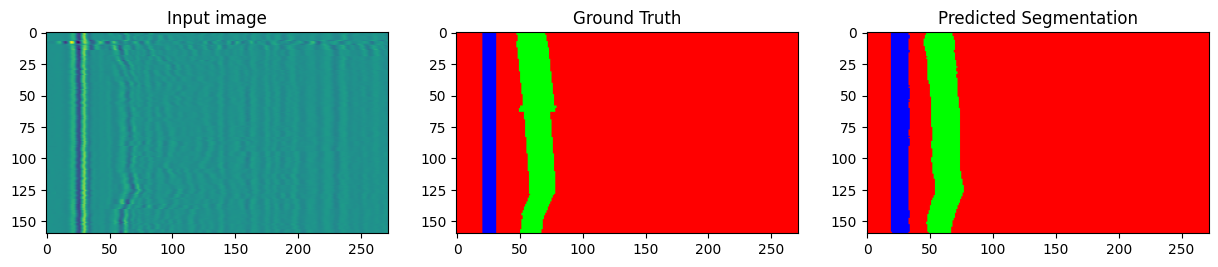

  0%|          | 0/54 [00:04<?, ?it/s]


In [45]:
for x,y in tqdm(dataloader):
    x = x.to('mps')
    y = y.permute(0, 2, 3, 1).to('mps')
    logits = model(x)[0]
    pred = torch.argmax(logits, dim=0)
    print(pred.shape)
    print(y.shape)
    print(y[0, 20, 25, :])

    pred = pred.cpu().detach().numpy()
    # Define RGB colors for each class
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue

    # Convert class indices to RGB colors
    segmentation_mask = colors[pred]  # Shape: (H, W, 3)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x[0].permute(1, 2, 0).cpu().detach().numpy())
    
    axs[0].set_title('Input image')

    axs[1].imshow(y[0].cpu().detach().numpy())
    axs[1].set_title('Ground Truth')

    axs[2].imshow(segmentation_mask)
    axs[2].set_title('Predicted Segmentation')

    plt.show()

    

    break